Trade Entry: 159.92 | Timestamp: 2025-06-03 09:45:00+00:00  | Take Proft: 162.34857142857143 | Stop Loss: 157.97714285714284  |  PnL: $40.00  |  Equity: $1040.00 | Volume: 14285
🟢Trade closed: 2025-06-03 14:45:00+00:00 | Target hit: 2025-06-03 14:45:00+00:00 | Exit: 163.2 | TP: 162.34857142857143
Trade Entry: 151.27 | Timestamp: 2025-06-09 08:30:00+00:00  | Take Proft: 153.34428571428572 | Stop Loss: 149.61057142857146  |  PnL: $41.60  |  Equity: $1081.60 | Volume: 15411
🟢Trade closed: 2025-06-09 09:30:00+00:00 | Target hit: 2025-06-09 09:30:00+00:00 | Exit: 153.66 | TP: 153.34428571428572
Trade Entry: 158.98 | Timestamp: 2025-06-10 09:45:00+00:00  | Take Proft: 161.27142857142854 | Stop Loss: 157.14685714285713  |  PnL: $43.26  |  Equity: $1124.86 | Volume: 36003
🟢Trade closed: 2025-06-10 11:30:00+00:00 | Target hit: 2025-06-10 11:30:00+00:00 | Exit: 161.12 | TP: 161.27142857142854
Trade Entry: 158.98 | Timestamp: 2025-06-10 18:30:00+00:00  | Take Proft: 162.33999999999997 | Stop Loss

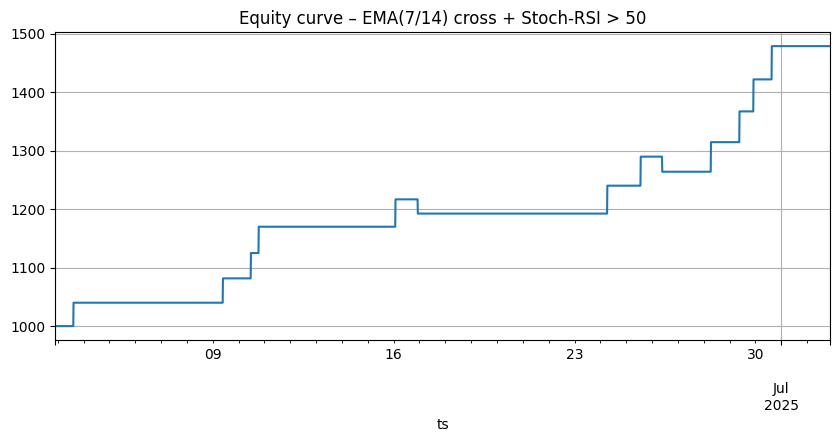

In [1]:
# pip install ccxt pandas numpy matplotlib
import ta, ccxt, pandas as pd, numpy as np, matplotlib.pyplot as plt

# ───────────────── CONFIG ───────────────────────────────────────────
PAIR, TF, LOOKBACK_D = "SOL/USDT", "15m", 30

RISK_PCT     = 0.02      # 2 % equity risk
ATR_MULT_SL  = 2.0       # stop  = 2×ATR14
ATR_MULT_TP  = 4.0       # target= 4×ATR14  (RR = 2:1)
ADX_FLOOR  = 20
VOL_MULT = 1.6      # volume multiplier for trend filter


# ───────────────── DOWNLOAD DATA ────────────────────────────────────
ex, rows = ccxt.bybit(), []
since = ex.milliseconds() - LOOKBACK_D * 86_400_000
while since < ex.milliseconds():
    chunk = ex.fetch_ohlcv(PAIR, TF, since=since, limit=1000)
    if not chunk: break
    rows.extend(chunk); since = chunk[-1][0] + 1

df = (pd.DataFrame(rows, columns="ts o h l c v".split())
        .assign(ts=lambda d: pd.to_datetime(d.ts, unit="ms", utc=True))
        .set_index("ts"))

# ───────────────── INDICATORS ───────────────────────────────────────
# EMAs
df["ema7"]  = df.c.ewm(span=7).mean()
df["ema14"] = df.c.ewm(span=14).mean()
df["ema28"] = df.c.ewm(span=28).mean()

# ATR14
tr  = np.maximum.reduce([df.h - df.l,
                         (df.h - df.c.shift()).abs(),
                         (df.l - df.c.shift()).abs()])
df["atr"] = pd.Series(tr, index=df.index).rolling(14).mean()

# RSI(14)
delta = df.c.diff()
gain  = delta.clip(lower=0).ewm(alpha=1/14, adjust=False).mean()
loss  = (-delta.clip(upper=0)).ewm(alpha=1/14, adjust=False).mean()
rs    = gain / loss
df["rsi"] = 100 - 100/(1+rs)

# Stoch-RSI 14,3,3
rsi_min = df.rsi.rolling(14).min()
rsi_max = df.rsi.rolling(14).max()
stoch_rsi = (df.rsi - rsi_min) / (rsi_max - rsi_min)
k_fast = stoch_rsi.rolling(3).mean() * 100           # %K
d_slow = k_fast.rolling(3).mean()                    # %D (not used here)
df["k_fast"] = k_fast

# Volume MA
df["vol20"] = df.v.rolling(20).mean()

# ADX
plus_dm  = np.where(df.h.diff()>df.l.diff(), df.h.diff().clip(lower=0), 0)
minus_dm = np.where(df.l.diff()>df.h.diff(), df.l.diff().abs(), 0)
tr_n     = pd.Series(tr,index=df.index).rolling(14).sum()
plus_di  = 100*pd.Series(plus_dm,index=df.index).rolling(14).sum()/tr_n
minus_di = 100*pd.Series(minus_dm,index=df.index).rolling(14).sum()/tr_n
dx       = 100*(plus_di-minus_di).abs()/(plus_di+minus_di)
df["adx"] = dx.rolling(14).mean()

# ───────────────── 1-H FRAME (trend filter) ──────────────────────
h1 = df.c.resample("1H").last().to_frame("close").ffill()
h1["ema50"]  = h1.close.ewm(span=50).mean()
h1["slope"]  = h1.ema50.diff(3)  # 3-bar slope

def h1_row(ts): return h1.loc[ts.floor("1H")]


# ───────────────── DAILY FRAME (bias filter) ─────────────────────
d1 = df.c.resample("1D").last().to_frame("close").ffill()
d1["ema50"]      = d1.close.ewm(span=50).mean()
d1["ema50_slope"] = d1.ema50.diff()          # +ve = rising



h4 = df.c.resample("4H").last().to_frame("close").ffill()
h4["ema50"] = h4.close.ewm(span=50).mean()

# ─── 8- & 12-HOUR BIAS FRAMES ────────────────────────────────────────
h8 = (
    df.c                       # use 15-minute closes
      .resample("8H")          # → 8-hour bars (00:00, 08:00, 16:00 UTC)
      .last()
      .to_frame("close")
      .ffill()
)
h8["ema50"]       = h8.close.ewm(span=50).mean()
h8["ema50_slope"] = h8.ema50.diff()           # rising > 0

h12 = (
    df.c
      .resample("12H")         # → 12-hour bars (00:00, 12:00 UTC)
      .last()
      .to_frame("close")
      .ffill()
)
h12["ema50"]       = h12.close.ewm(span=50).mean()
h12["ema50_slope"] = h12.ema50.diff()

# helpers – call with the current 15-m timestamp (idx)
def bias_8h(ts):
    r = h8.loc[ts.floor("8H")]
    return (r.close > r.ema50) and (r.ema50_slope > 0)

def bias_12h(ts):
    r = h12.loc[ts.floor("12H")]
    return (r.close > r.ema50) and (r.ema50_slope > 0)

def h4_bias(ts):
    r = h4.loc[ts.floor("4H")]
    return r.close > r.ema50

def d1_row(ts):            # helper: row for the current UTC day
    return d1.loc[ts.floor("1D")]


# EMA-cross detector
# simlar winrate/less drawdown
# cross_up = (df.ema7 > df.ema14) & (df.ema7.shift() <= df.ema14.shift()) & (df.ema28 > df.ema14) & (df.ema28 > df.ema7) 
# Standard
cross_up = (df.ema7 > df.ema14) & (df.ema7.shift() <= df.ema14.shift())

# df["long_signal"] = cross_up & (df.k_fast > 45) & (df.k_fast < 80) & (df.rsi > 50) 
# df["candle_confirm"] = (df.c > df.ema7) & (df.o > df.ema7)
# df["vol_spike"] = df.v > 2 * df.v.rolling(5).mean()


df["long_signal"] = cross_up & (df.k_fast > 45) & (df.rsi > 50)


# ───────────────── SIMPLE BACK-TEST ────────────────────────────────
equity, curve = 1_000.0, []
pos = None
trades = []
GOOD_HOURS = set(range(14, 23))          # 14-22 UTC inclusive

for idx, bar in df.iterrows():

    # -------- manage open trade --------
    if pos:
        hit_sl = bar.l <= pos["sl"]
        hit_tp = bar.h >= pos["tp"]

        if hit_sl or hit_tp:
            pnl = -pos["risk"] if hit_sl else pos["risk"] * (ATR_MULT_TP/ATR_MULT_SL)
            equity += pnl
            trades.append({"exit": idx, "pnl": pnl})
            pos['time_close'] = idx
            print (f"Trade Entry: {pos['entry']} | Timestamp: {pos['time_entry']}  | Take Proft: {pos['tp']} | Stop Loss: {pos['sl']}  |  PnL: ${pnl:.2f}  |  Equity: ${equity:.2f} | Volume: {bar.v:.0f}")
            if hit_tp:
                print(f"🟢Trade closed: {idx} | Target hit: {pos['time_close']} | Exit: {bar.c} | TP: {pos['tp']}")
            elif hit_sl:
                print(f"🔴Trade closed: {idx} | Stop Loss hit: {pos['time_close']} | Exit: {bar.c} | SL: {pos['sl']}")
                
            pos = None
         # take half at +1 R
        elif not pos['half'] and (bar.c-pos['entry'])>=pos['risk']:
            equity+=0.5*pos['risk']; pos['half']=True
        # trail remainder
        if pos and pos['half']: 
            new_sl = bar.c - ATR_MULT_SL * bar.atr
            if new_sl > pos["sl"]:
                pos["sl"] = new_sl

    # vol_ok = bar.v   >= VOL_MULT*bar.vol20
    H = h1_row(bar.name)
    # -------- new entry --------

    # -------- new entry --------
    if pos is None and bar.long_signal and bar.adx>=ADX_FLOOR:  # trend filter
        H = h1_row(idx)
        # if not h1_row(idx).slope > 0:  # trend filter
        #   curve.append(equity)
        #   continue            # skip counter-trend signals

        # if not h4_bias(idx):
        #     curve.append(equity)
        #     continue            # skip counter-trend signals

      # skip this 15-m signal
        # if idx.hour not in GOOD_HOURS:
        #     curve.append(equity);  bullish
        
        if(H.close > H.ema50) and (H.slope > 0):   # 1-h bias bearish
            stop_dist = ATR_MULT_SL * bar.atr * 1.6
            if stop_dist > 0:
                risk_per_unit = equity * RISK_PCT
                pos = dict(
                time_entry=idx,
                time_close =None,
                entry=bar.c,
                sl   = bar.c - stop_dist,
                tp   = bar.c + ATR_MULT_TP * bar.atr,
                   risk = risk_per_unit,
                   half=False)


    curve.append(equity)

# ───────────────── RESULTS ─────────────────────────────────────────
eq_series = pd.Series(curve, index=df.index[-len(curve):])
wins = sum(1 for t in trades if t["pnl"] > 0)
print(f"Trades: {len(trades)}  |  Wins: {wins}  |  Win-rate: {wins/len(trades):.1%}")
print(f"Final balance: ${equity:,.0f}  |  Max DD: {100*(min(eq_series)-1_000)/1_000:.1f}%")

eq_series.plot(title="Equity curve – EMA(7/14) cross + Stoch-RSI > 50", figsize=(10,4), grid=True)
plt.show()
